In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df_aep = pd.read_csv("data/AEP_hourly.csv")
df_aep.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'}, inplace=True)
df_aep['ds'] = pd.to_datetime(df_aep['ds'], format='%Y-%m-%d %H:%M:%S')
out_dir = 'AEP_results'

In [7]:
import RNN_fourier_RNN_uncertainty
import pickle

train_config = RNN_fourier_RNN_uncertainty.training_config(n_epochs=3, device=torch.device("mps"))
fourier_conf = RNN_fourier_RNN_uncertainty.fourier_config(mode="matrix", K_weekly=3, K_monthly=6, K_yearly=10)

K_total = fourier_conf.K_weekly + fourier_conf.K_monthly + fourier_conf.K_yearly
F_per_hour = 2 * K_total

if fourier_conf.mode == "vector":
    cont_dim = 1 + F_per_hour
    fourier_dim = F_per_hour
else:
    cont_dim = 1 + 24 * F_per_hour
    fourier_dim = F_per_hour

results_fourier = pd.DataFrame({'day': [], 'hour': [], 'y_hat': [], 'y':[], 'y_hat_lower': [], 'y_hat_upper': [], 'p_values': []})
train_residuals_results = {}
epsilon_params_results = {}
date_start = pd.to_datetime('2004-10-01 00:00:00')
date_end = pd.to_datetime('2008-10-01 00:00:00')

i = 1

while True:
    print(i)
    df_reduced = df_aep.loc[(df_aep['ds'] >= date_start) & (df_aep['ds'] < date_end)].copy()
    model = RNN_fourier_RNN_uncertainty.RNN_fourier(cont_dim=cont_dim, fourier_dim=fourier_dim, xf_mode="matrix",
                                                    d_model=128,latent_dim=32,nhead=4)
    trainer = RNN_fourier_RNN_uncertainty.RNN_train_fourier(model, train_config, fourier_conf)
    train_results = trainer(df_reduced)

    forcast = train_results['test_pred']
    true = train_results['test_true']
    train_residuals = train_results['train_residuals']
    epsilon_params = {'mean': train_results['epsilon_mean'], 'cov': train_results['epsilon_cov']}

    result = pd.DataFrame({'day': df_reduced['ds'].dt.date.max(), 'hour': list(range(24)), 'y_hat': forcast, 'y': true,
                           'y_hat_lower': train_results['y_pred_lower'], 'y_hat_upper': train_results['y_pred_upper'],
                           'p_values': train_results['p_values']})
    results_fourier = pd.concat([results_fourier, result]).reset_index(drop=True)
    train_residuals_results[str(df_reduced['ds'].dt.date.max())] = train_residuals
    epsilon_params_results[str(df_reduced['ds'].dt.date.max())] = epsilon_params

    date_start += pd.Timedelta(days=1)
    date_end += pd.Timedelta(days=1)
    if i % 5 == 0:
        results_fourier.to_csv('experiment_results/' + out_dir + '/results_fourier.csv', index=False)
    if i == 70:
        print('finish')
        break
    else:
        i += 1

results_fourier.to_csv('experiment_results/' + out_dir + '/results_fourier.csv', index=False)

with open('experiment_results/' + out_dir + '/train_residuals_results.pkl', 'wb') as f:
    pickle.dump(train_residuals_results, f)

with open('experiment_results/' + out_dir + '/epsilon_params_results.pkl', 'wb') as f:
    pickle.dump(epsilon_params_results, f)


1
epoch 1 loss: 0.3636
epoch 2 loss: 0.2293
epoch 3 loss: 0.1423


/var/folders/3h/5yfj7yqx7lg98t310bfxxr3m0000gn/T/ipykernel_18489/1427466194.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_fourier = pd.concat([results_fourier, result]).reset_index(drop=True)


2
epoch 1 loss: 0.6416
epoch 2 loss: 0.2367
epoch 3 loss: 0.1571
3
epoch 1 loss: 0.6696
epoch 2 loss: 0.2957


KeyboardInterrupt: 

In [8]:
results_fourier

,day,hour,y_hat,y,y_hat_lower,y_hat_upper,p_values
0,2008-09-30,0.0,14281.595703,14260.0,13057.856890,15499.435071,0.74876
1,2008-09-30,1.0,13164.911133,13410.0,11959.971600,14368.063388,0.91550
2,2008-09-30,2.0,12571.455078,12818.0,11204.154176,13935.514118,0.91038
3,2008-09-30,3.0,12212.634766,12543.0,10804.300389,13613.427379,0.79818
4,2008-09-30,4.0,12079.150391,12348.0,10575.597015,13579.026711,0.89396
5,2008-09-30,5.0,12245.392578,12480.0,10431.786468,14039.697982,0.99194
6,2008-09-30,6.0,12662.700195,13164.0,11083.994846,14245.618352,0.65970
7,2008-09-30,7.0,13444.752930,14734.0,11605.829101,15273.048231,0.19460
8,2008-09-30,8.0,14296.239258,15478.0,12458.078560,16127.957237,0.25900
9,2008-09-30,9.0,14710.835938,15541.0,13201.361480,16213.343515,0.41104


In [27]:
with open('experiment_results/uncertainty_results/train_residuals_results.pkl', 'rb') as f:
    train_residuals_results = pickle.load(f)

In [29]:
train_residuals_results.keys()

dict_keys(['2008-09-30', '2008-10-01', '2008-10-02', '2008-10-03', '2008-10-04', '2008-10-05', '2008-10-06', '2008-10-07', '2008-10-08', '2008-10-09', '2008-10-10', '2008-10-11', '2008-10-12', '2008-10-13', '2008-10-14', '2008-10-15', '2008-10-16', '2008-10-17', '2008-10-18', '2008-10-19', '2008-10-20', '2008-10-21', '2008-10-22', '2008-10-23', '2008-10-24', '2008-10-25', '2008-10-26', '2008-10-27', '2008-10-28', '2008-10-29', '2008-10-30', '2008-10-31', '2008-11-01', '2008-11-02', '2008-11-03', '2008-11-04', '2008-11-05', '2008-11-06', '2008-11-07', '2008-11-08', '2008-11-09', '2008-11-10', '2008-11-11', '2008-11-12', '2008-11-13', '2008-11-14', '2008-11-15', '2008-11-16', '2008-11-17', '2008-11-18', '2008-11-19', '2008-11-20', '2008-11-21', '2008-11-22', '2008-11-23', '2008-11-24', '2008-11-25', '2008-11-26', '2008-11-27', '2008-11-28', '2008-11-29', '2008-11-30', '2008-12-01', '2008-12-02', '2008-12-03', '2008-12-04', '2008-12-05', '2008-12-06', '2008-12-07', '2008-12-08'])

In [8]:
result1 = pd.read_csv('new_exp_results/' + out_dir + '/results_fourier.csv')

In [12]:
result1.iloc[:5*24,]

,day,hour,y_hat,y,y_hat_lower,y_hat_upper
0,2008-09-30,0.0,14049.407,14260.0,13458.820756,14632.781290
1,2008-09-30,1.0,13110.682,13410.0,12516.516071,13706.276919
2,2008-09-30,2.0,12642.773,12818.0,12031.389900,13259.789923
3,2008-09-30,3.0,12335.580,12543.0,11689.916075,12987.666702
4,2008-09-30,4.0,12255.514,12348.0,11574.034142,12948.189543
...,...,...,...,...,...,...
115,2008-10-04,19.0,14528.019,13782.0,13678.068743,15378.699231
116,2008-10-04,20.0,14719.655,14331.0,13917.978999,15523.620453
117,2008-10-04,21.0,14632.840,14562.0,13901.620256,15365.460267
118,2008-10-04,22.0,14109.245,14262.0,13371.382026,14853.113085


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Dict, Tuple
import seaborn as sns

In [17]:
k = 5*24
result1.loc[:k-1,'y_hat_lower']

0      13458.820756
1      12516.516071
2      12031.389900
3      11689.916075
4      11574.034142
           ...     
116    13917.978999
117    13901.620256
118    13371.382026
119    12609.644950
120    12237.965627
Name: y_hat_lower, Length: 121, dtype: float64

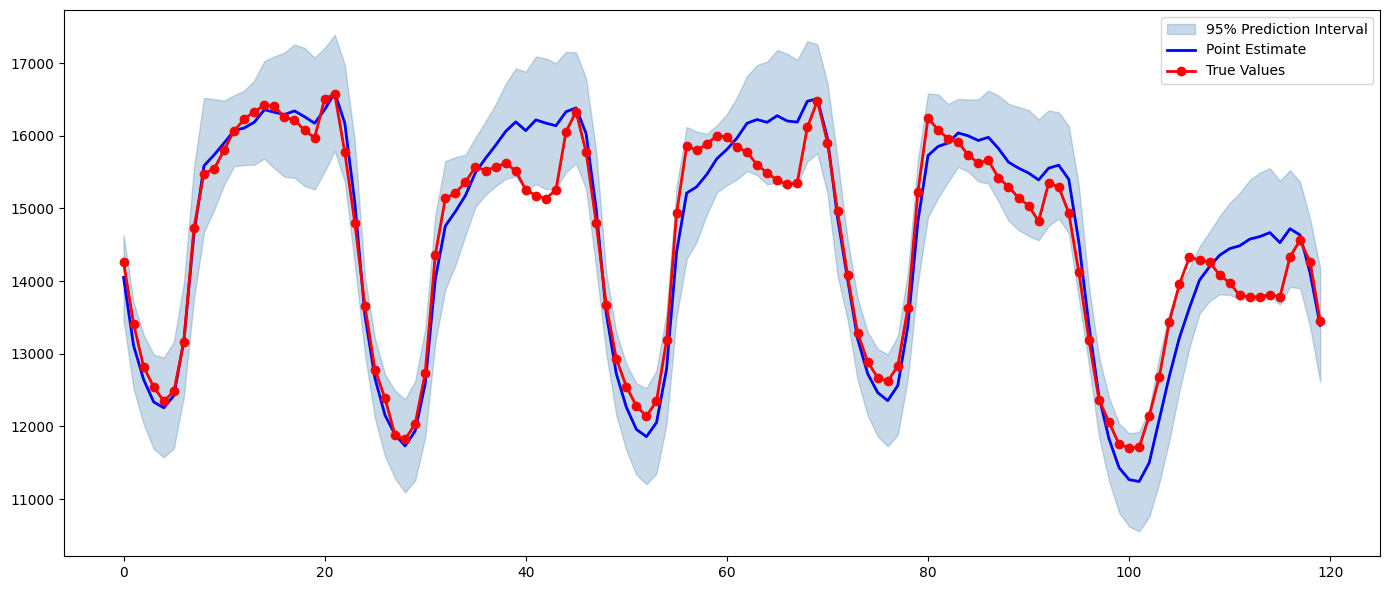

In [19]:
k = 5*24
hours = np.arange(k)
fig, ax = plt.subplots(figsize=(14, 6))
ax.fill_between(hours, result1['y_hat_lower'][:k], result1['y_hat_upper'][:k],
                     alpha=0.3, color='steelblue', label='95% Prediction Interval')
ax.plot(hours, result1['y_hat'][:k], 'b-', linewidth=2, label='Point Estimate')
ax.plot(hours, result1['y'][:k], 'ro-', linewidth=2, markersize=6, label='True Values')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()